In [1]:
import random
import torch


words = open('words.txt', 'r').read().splitlines()
words = sorted(list(set(words))) # set cause uncontrollable randomness, sorted for reproducibility
max_len = max(len(w) for w in words)
random.seed(42)
random.shuffle(words)

chs = list(set(''.join(words + ['.']))) # add special token
chs = sorted(chs, reverse=False)
stoi = {ch: i for i, ch in enumerate(chs)}
itos = {i: ch for i, ch in enumerate(chs)}

# predict next token use previous tokens
vocab_size = len(chs)
block_size = max_len + 1
X, Y = [], []

for w in words:
    x = torch.zeros(max_len + 1, dtype=torch.long)
    y = torch.zeros(max_len + 1, dtype=torch.long)
    x[1:1+len(w)] = torch.tensor([stoi[ch] for ch in w])
    y[:len(w)] = torch.tensor([stoi[ch] for ch in w])
    y[len(w)+1:] = -1 # mask the loss at the inactive locations
    X.append(x)
    Y.append(y)

X = torch.stack(X)
Y = torch.stack(Y)
n1, n2  = int(0.8 * len(X)), int(0.9 * len(X))

# split data into train, validation, and test
X_train, X_val, X_test = X.tensor_split([n1, n2])
Y_train, Y_val, Y_test = Y.tensor_split([n1, n2])

show = 20
for x, y in zip(X_train[:show], Y_train[:show]):
    sx = ''.join(itos[i.item()] for i in x)
    sy = ''.join(itos[i.item()] for i in y if i.item() != -1)
    print(f'{sx} -> {sy}')

X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape


.exodus............ -> exodus.
.omened............ -> omened.
.sugars............ -> sugars.
.wide.............. -> wide.
.plugged........... -> plugged.
.bounds............ -> bounds.
.uman.............. -> uman.
.authoritarian..... -> authoritarian.
.benedicta......... -> benedicta.
.stepsister........ -> stepsister.
.neatest........... -> neatest.
.dreaming.......... -> dreaming.
.ceremoniously..... -> ceremoniously.
.harder............ -> harder.
.misunderstandings. -> misunderstandings.
.governed.......... -> governed.
.scarped........... -> scarped.
.goodish........... -> goodish.
.closer............ -> closer.
.countersign....... -> countersign.


(torch.Size([23367, 19]),
 torch.Size([2921, 19]),
 torch.Size([2921, 19]),
 torch.Size([23367, 19]),
 torch.Size([2921, 19]),
 torch.Size([2921, 19]))

In [2]:
from dataclasses import dataclass
from tiny_torch_nn import *


@dataclass
class ModelConfig:
    block_size: int = block_size # length of the input sequences of integers
    vocab_size: int = vocab_size # the input integers are in range [0 .. vocab_size -1]
    n_layer: int = 4
    n_embd: int = 64
    n_embd2: int = 64
    n_head: int = 4
    dtype: torch.dtype = torch.float64
    
def generate(model, idx, max_new_tokens, temperature=1.0, do_sample=False, top_k=None, generator=None):
    """
    Predict the next token in the sequence.
    """
    block_size = model.get_block_size()
    for _ in range(max_new_tokens):
        idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]
        logits = model(idx_cond)
        logits = logits[:, -1, :] / temperature
        # only select top k tokens
        if top_k is not None:
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float('Inf')
        probs = logits.softmax(dim=-1)
        if do_sample:
            idx_next = torch.multinomial(probs, num_samples=1, generator=generator)
        else: # greedy sampling
            _, idx_next = torch.topk(probs, k=1, dim=-1)
        idx = torch.cat((idx, idx_next), dim=1)
        if idx_next.item() == 0:
            break
    return idx

def sample(models, generator=None):
    """
    Generate 10 samples from each model.
    """
    for _ in range(10):
        s_list = []
        for name, model in models.items():
            tks = generate(model, torch.tensor([[0]]), max_new_tokens=10, do_sample=True, generator=generator)[0].tolist()
            s = ''.join(itos[i] for i in tks)
            s_list.append(s)
        out = ' | '.join(f'{name}: {s:<13s}' for name, s in zip(models.keys(), s_list))
        print(f'{out}')


In [3]:
# set seed for reproducibility
torch.manual_seed(42)

# keep all models roughly the same size
model_bigram = Bigram(ModelConfig(block_size=block_size, vocab_size=vocab_size, n_embd=74))
model_mlp = MLP(ModelConfig(block_size=block_size, vocab_size=vocab_size, n_embd=8, n_embd2=21))
model_rnn = RNN(ModelConfig(block_size=block_size, vocab_size=vocab_size, n_embd=8, n_embd2=46))
model_gru = GRU(ModelConfig(block_size=block_size, vocab_size=vocab_size, n_embd=8, n_embd2=28))
model_transformer = Transformer(ModelConfig(block_size=block_size, vocab_size=vocab_size, n_embd=15, n_head=1, n_layer=1))
models = {
    'bigram': model_bigram,
    'mlp': model_mlp,
    'rnn': model_rnn,
    'gru': model_gru,
    'transformer': model_transformer
}

# initially, the model generates random characters
g = torch.Generator().manual_seed(42)
sample(models, generator=g)


number of bigram parameters: 4070
number of mlp parameters: 4031
number of rnn parameters: 4061
number of gru parameters: 4135
number of transformer parameters: 4020
bigram: .xjugueovtp   | mlp: .s.           | rnn: .fabiquedxf   | gru: .mubnwmsfla   | transformer: .ypgyzofmwh  
bigram: .wgx.         | mlp: .ln.          | rnn: .epjccuodsg   | gru: .jdmzu.       | transformer: .xnpcmjjobd  
bigram: .rggbulpk.    | mlp: .mnqhqyjfbh   | rnn: .cvghigeacz   | gru: .alcvjwiajw   | transformer: .tphjpdmqso  
bigram: .tcc.         | mlp: .welqxosvgk   | rnn: .ohobr.       | gru: .uklnncvrig   | transformer: .myrysoumf.  
bigram: .pjjiewx.     | mlp: .lxljuhm.     | rnn: .fsckbirdov   | gru: .hgn.         | transformer: .kgoktfkzua  
bigram: .cabxa.       | mlp: .atodr.       | rnn: .bxwqljcdq.   | gru: .tmdampemaq   | transformer: .j.          
bigram: .omtafjiirv   | mlp: .qtlpkyeumx   | rnn: .uoztame.     | gru: .evzqmyiog.   | transformer: .acdtqumkor  
bigram: .vkyxkhlsog   | mlp: .ob.   

In [4]:
# args
n_steps = 20000
eval_every = 1000
bs = 32
ini_lr = 0.1

# all models use the same loss function
loss_fns = [CrossEntropyLoss3d() for _ in range(len(models))]
val_loss_fn = CrossEntropyLoss3d()
optimizers = [SGD(model, lr=ini_lr) for model in models.values()]

# train
lossi = []
for  step in range(n_steps):
    idx = torch.randint(0, X_train.shape[0], (bs,))
    x, y = X_train[idx], Y_train[idx]
    lr = ini_lr if step < int(n_steps * 0.75) else ini_lr * 0.1
    for optimizer in optimizers:
        optimizer.lr = lr

    losses = []
    for (name, model), loss_fn, optimizer in zip(models.items(), loss_fns, optimizers):
        # forward
        logits = model(x)
        loss = loss_fn(logits, y)
        # backward
        dlogits = loss_fn.backward(loss)
        model.backward(dlogits)
        # update
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss)
    lossi.append(losses)
    
    if step % eval_every == 0 or step == n_steps - 1:
        x, y = X_val, Y_val
        val_losses = []
        for name, model in models.items():
            logits = model(x)
            val_loss = val_loss_fn(logits, y, ignore_index=-1)
            val_losses.append(val_loss)
        loss_out = f' | '.join(f'{name}: {loss.item():.4f}' for name, loss in zip(models.keys(), losses))
        val_loss_out = f' | '.join(f'{name}: {val_loss.item():.4f}' for name, val_loss in zip(models.keys(), val_losses))
        print(f'step {step+1:<5} || Train || {loss_out} || Val || {val_loss_out}')




step 1     || Train || bigram: 3.3068 | mlp: 3.2924 | rnn: 3.2893 | gru: 3.2984 | transformer: 3.2964 || Val || bigram: 3.2142 | mlp: 3.2390 | rnn: 3.2728 | gru: 3.2889 | transformer: 3.2579
step 1001  || Train || bigram: 2.5999 | mlp: 2.4899 | rnn: 2.4234 | gru: 2.4677 | transformer: 2.4680 || Val || bigram: 2.5129 | mlp: 2.4304 | rnn: 2.3276 | gru: 2.3988 | transformer: 2.3942
step 2001  || Train || bigram: 2.5124 | mlp: 2.3395 | rnn: 2.2241 | gru: 2.3002 | transformer: 2.3267 || Val || bigram: 2.5082 | mlp: 2.3607 | rnn: 2.2508 | gru: 2.3062 | transformer: 2.3337
step 3001  || Train || bigram: 2.4838 | mlp: 2.3233 | rnn: 2.1606 | gru: 2.1793 | transformer: 2.2279 || Val || bigram: 2.5039 | mlp: 2.3248 | rnn: 2.2079 | gru: 2.2529 | transformer: 2.2944
step 4001  || Train || bigram: 2.5989 | mlp: 2.4127 | rnn: 2.3329 | gru: 2.3788 | transformer: 2.4192 || Val || bigram: 2.5043 | mlp: 2.2991 | rnn: 2.1829 | gru: 2.2242 | transformer: 2.2627
step 5001  || Train || bigram: 2.5030 | mlp: 

In [5]:
x, y = X_test, Y_test
test_losses = []
for name, model in models.items():
    logits = model(x)
    test_loss = val_loss_fn(logits, y, ignore_index=-1)
    test_losses.append(test_loss)
test_loss_out = f' | '.join(f'{name}: {test_loss.item():.4f}' for name, test_loss in zip(models.keys(), test_losses))
print(f'test || {test_loss_out}')

print()

# after training, the model generates words that are more similar to English
g = torch.Generator().manual_seed(42)
sample(models, generator=g)


test || bigram: 2.4835 | mlp: 2.2056 | rnn: 2.0948 | gru: 2.1171 | transformer: 2.1681

bigram: .ctugedove.   | mlp: .s.           | rnn: .fabidus.     | gru: .xumest.      | transformer: .millay.     
bigram: .g.           | mlp: .cotser.      | rnn: .prole.       | gru: .epiccenden   | transformer: .lespe.      
bigram: .blecong.     | mlp: .bergom.      | rnn: .dep.         | gru: .momolynabe   | transformer: .cvusined.   
bigram: .selamitint   | mlp: .cluctly.     | rnn: .asotch.      | gru: .sentiously   | transformer: .shops.      
bigram: .cklencrort   | mlp: .minish.      | rnn: .stip.        | gru: .sirwodlimj   | transformer: .unm.        
bigram: .ffiobindin   | mlp: .hon.         | rnn: .brow.        | gru: .folued.      | transformer: .bau.        
bigram: .atodretire   | mlp: .licdove.     | rnn: .damperably   | gru: .sharetiles   | transformer: .stlak.      
bigram: .s.           | mlp: .moucstame.   | rnn: .ensquiize.   | gru: .achonuhhor   | transformer: .incarhison  


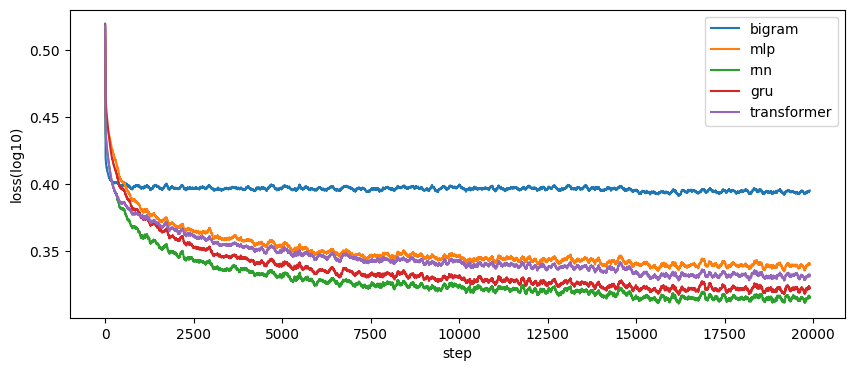

In [6]:
import matplotlib.pyplot as plt

def avg_loss(losses, window=100):
    ini_loss = losses[:10]
    avg_loss = losses[10:].unfold(0, window, 1).mean(1)
    return torch.cat([ini_loss, avg_loss]) # first 10 steps are not averaged, otherwise the initial losses are different

lossi = torch.tensor(lossi) if not isinstance(lossi, torch.Tensor) else lossi
log_lossi = lossi.log10()
model_names = list(models.keys())

plt.figure(figsize=(10, 4))
for i in range(log_lossi.shape[1]):
    plt.plot(avg_loss(log_lossi[:, i]), label=f'{model_names[i]}')
plt.xlabel('step')
plt.ylabel('loss(log10)')
plt.legend()
plt.show()



